# Python wrapper for Orbit3d

---

To compile python extension module using f2py:

    f2py -c orbit3D_f2py.f90 -m orbit3D
    
where *orbit3D_f2py.f90* is the source code and *orbit3D* is the name of the Python module

For proper frequency resolution in the FFT, make sure that time period is 1.0s or more:

* For an impeller speed of **1500rpm**, this is equivalent to **25** revolutions
* For an impeller speed of **2500rpm**, this is equivalent to **40** revolutions

---

In [1]:
import numpy as np
%matplotlib inline
from matplotlib.pyplot import *
import scipy, scipy.signal
from numpy import pi

In [2]:
import orbit3D
#print orbit3D.orbit3d.__doc__

In [3]:
# Functions to convert dimensional inputs to non-dimensional inputs

def RadPerSecToRPM(radpersec):
    return radpersec * (180/np.pi) / 360. * 60.

def RPMtoRPS(rpm):
    return rpm/60.

def RPMtoRadPerSec(rpm):
    return rpm / 60. * 360. / (180/np.pi)

def getM1(c,omega,g):
    return c*omega**2 / g

def getLAMBDA(c,omega,eta,r1,r2,F):
    L = r2-r1
    return (6*eta*omega*L**2)/(F) * (r2/c)**2

def getIT(c,omega,eta,r1,r2,it):
    L = r2-r1    
    return (c**2 * omega)/(6*eta*L**2*r2**3)*it

def myround(x, base=5):
    import math
    return int(base * math.ceil(float(x)/base))

In [101]:
# USER INPUTS

rpm       = 1000                  # Rotational speed of impeller (RPM)
eta       = 3.5e-3                # Viscosity of blood (Pa.s??)
ALPD      = 45.0                  # Conical half angle of conical journal bearing
TH0D      = 45.0                  # Angular span of each impeller blade
R1,R2     = 0.0125,0.025          # Inner, outer radius of thrust bearing (m)
m         = 36.0                  # Impeller mass (back calculated)
I_t       = 4.192773e-06          # Transverse moment of inertia (m^4??). Back calculated
g         = 9.81                  # Gravitational constant (m/s^2)
H0        = 100e-6                # Clearance at leading edge
H1        = 150e-6                # Clearance at trailing edge
PL        = 0.2                   # Fraction of angular span of bearing that is untapered land
v1,v2     = 10.0,0.0              # Shaking frequency (Hz)
xh,yh,zh  = 4.5,0.0,0.0           # X,Y,Z amplitudes of shaking force (mm)
PHI1,PHI2 = pi, 0.0               # Orientation of gravity vector (radians)
Yinit     = np.zeros(10)          # Initial values for Y1-Y10
N1        = 31                    # N1 = NTH = NR = NRO. Should be between 21 and 51
N2        = 4                     # N2 = NP. Number of impeller bearings
REV       = 10.0                  # Number of impeller revolutions (2*pi*REV = non-dim time duration)
omega     = RPMtoRadPerSec(rpm)   # Rotational speed of impeller (rad/s)
tp        = 2.0*pi*REV/(omega)    # Time period (dimen, s)
DT_deg    = 0.5                   # Time step (non-dim, degrees)
M2        = 0.0                   # Unbalance mass (non-dim)
JP        = 1.78578               # Non-dim polar moment of inertia, I_p / I_t

In [102]:
# Convert to non-dimensional values

F         = m*g/1000.                                 # Force on impeller
M1        = getM1(H0,omega,g)                         # Impeller mass (non-dim)
LOADP     = getLAMBDA(H0,omega,eta,R1,R2,F)           # Load factor (non-dim)
IT        = getIT(H0,omega,eta,R1,R2,I_t)             # Transverse moment of inertia (non-dim)
XH,YH,ZH  = [v/1000./H0 for v in [xh,yh,zh]]          # X,Y,Z amplitudes of shaking force (multiples of H0) (non-dim)      
V1,V2     = v1/RPMtoRPS(rpm),0.0                      # Frequencies of (a) shaking force and (b) unbalance mass (non-dim)
tpnd      = tp*omega                                  # Time period (non-dim)
NT        = int((tpnd/np.radians(DT_deg))+1)          # Number of time steps

In [103]:
# Summary of inputs
print 'SUMMARY:\n'
print 'omega = %.3f rad/s = %.1f rev/s' % (omega,RPMtoRPS(rpm))
print 'time  = %.3f s = %.3f [non-dim]' % (tp,tpnd)
print 'rev   = %.3f revolutions' % REV
print 'V1    = %.3f Hz = %.3f [non-dim]' % (v1,V1)
print 'V2    = %.3f' % V2
print 'NT    = %d' % NT
print 'LOADP = %.1f' % LOADP

SUMMARY:

omega = 104.720 rad/s = 16.7 rev/s
time  = 0.600 s = 62.832 [non-dim]
rev   = 10.000 revolutions
V1    = 10.000 Hz = 0.600 [non-dim]
V2    = 0.000
NT    = 7200
LOADP = 60.8


In [104]:
# Setup empty output arrays
tnd  = np.zeros(NT)
erx  = np.zeros(NT)
ery  = np.empty(NT)
erz  = np.zeros(NT)
rotx = np.zeros(NT)
roty = np.zeros(NT)

In [105]:
# Run Orbit3D
orbit3D.orbit3d(ALPD,TH0D,R1,R2,IT,JP,H0,H1,PL,M1,M2,XH,YH,
                ZH,V1,V2,PHI1,PHI2,Yinit,LOADP,REV,N1,N2,
                tnd,erx,ery,erz,rotx,roty)

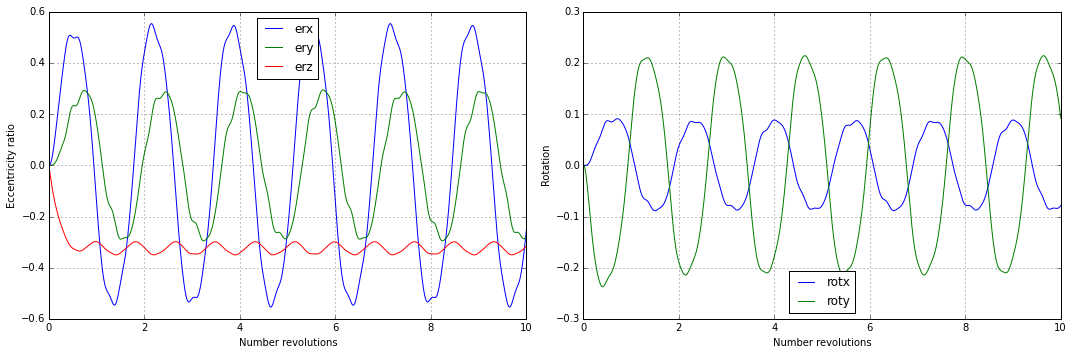

In [106]:
fig, axes = subplots(1,2)
fig.set_size_inches([15,5])
ax1,ax2 = axes
ax1.plot(tnd/(2*np.pi),erx,label='erx')
ax1.plot(tnd/(2*np.pi),ery,label='ery')
ax1.plot(tnd/(2*np.pi),erz,label='erz')
ax1.set_xlim([0,REV])
ax1.set_xlabel('Number revolutions')
ax1.set_ylabel('Eccentricity ratio')
ax1.legend(loc=0)
ax1.grid()
ax2.plot(tnd/(2*np.pi),rotx,label='rotx')
ax2.plot(tnd/(2*np.pi),roty,label='roty')
ax2.set_xlim([0,REV])
ax2.set_xlabel('Number revolutions')
ax2.set_ylabel('Rotation')
ax2.legend(loc=0)
ax2.grid()

fig.tight_layout()

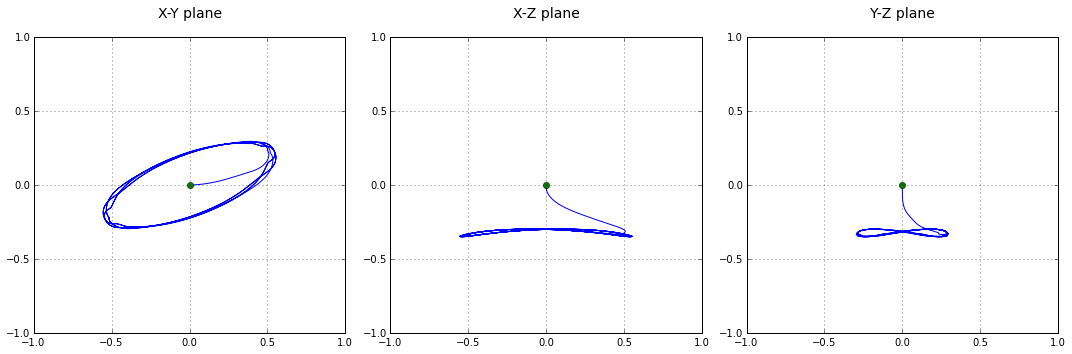

In [107]:
fig, axes = subplots(1,3)
fig.set_size_inches([15,5])
for ax in axes:
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1]) 
    ax.grid()
ax1,ax2,ax3 = axes
ax1.plot(erx,ery)
ax1.plot(Yinit[0],Yinit[2],'o')
ax1.set_title('X-Y plane',y=1.05,fontsize=14)
ax2.plot(erx,erz)
ax2.plot(Yinit[0],Yinit[4],'o')
ax2.set_title('X-Z plane',y=1.05,fontsize=14)
ax3.plot(ery,erz)
ax3.plot(Yinit[2],Yinit[4],'o')
ax3.set_title('Y-Z plane',y=1.05,fontsize=14)
fig.tight_layout()

In [108]:
# Functions for fft

def tukey(numPoints,alpha=0.5):
    import numpy as np
    if   alpha <=0: return np.ones(numPoints)
    elif alpha >=1: return np.hanning(numPoints)
    x = np.linspace(0,1,numPoints)
    w = np.ones(x.shape)
    # First condition 0<=x<alpha/2
    c1    = x<alpha/2
    w[c1] = 0.5*(1 + np.cos(2*pi/alpha*(x[c1]-alpha/2))) 
    # Second condition 1-alpha/2 <= x <= 1
    c2    = x>=(1-alpha/2)
    w[c2] = 0.5*(1 + np.cos(2*pi/alpha*(x[c2]-(1-alpha/2))))
    return w

def getSignalFrequencies(t,y):
    
    # Apply window function to original signal
    dt = np.average(np.diff(t))
    numPoints = len(t)
    window = tukey(numPoints,0.1)
    y_avg  = np.average(y)
    y_orig = y-y_avg
    y_win  = y_orig * window

    # Perform FFT
    freqHz     = np.fft.fftfreq(int(numPoints),dt)  # Get frequencies 
    freqData   = np.fft.fft(y_win)*(2./numPoints)   # Normalise fft to get correct spectrum amplitudes
    nyquistIdx = int(numPoints)/2                   # Get the Nyquist frequency, or half the sampling frequency
    freqHz     = freqHz[:nyquistIdx]                # Get frequencies less than the Nyquist frequency
    freqData   = freqData[:nyquistIdx]              # Get the frequency data
    rFreqData  = abs(freqData)                      # Get real component
    
    return y_orig,y_win,freqHz,rFreqData

In [109]:
# Perform fft

orig_erx,win_erx,freq_erx,amp_erx = getSignalFrequencies(tnd/omega,erx)
orig_ery,win_ery,freq_ery,amp_ery = getSignalFrequencies(tnd/omega,ery)
orig_erz,win_erz,freq_erz,amp_erz = getSignalFrequencies(tnd/omega,erz)

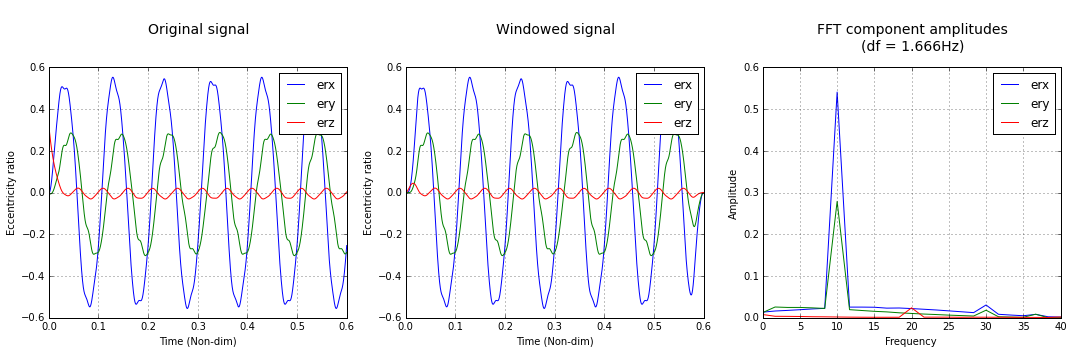

In [114]:
# Plot results

fig, (ax1,ax2,ax3) = subplots(1,3)
fig.set_size_inches(15,5)

ax1.plot(tnd/omega,orig_erx,label='erx')
ax1.plot(tnd/omega,orig_ery,label='ery')
ax1.plot(tnd/omega,orig_erz,label='erz')
ax1.set_title('\nOriginal signal\n',y=1.05,fontsize=14)
ax1.set_xlabel('Time (Non-dim)')
ax1.set_ylabel('Eccentricity ratio')
ax1.set_xlim([0,tp])
ax1.legend(loc=0)
ax1.grid()

ax2.plot(tnd/omega,win_erx,label='erx')
ax2.plot(tnd/omega,win_ery,label='ery')
ax2.plot(tnd/omega,win_erz,label='erz')
ax2.set_title('\nWindowed signal\n',y=1.05,fontsize=14)
ax2.set_xlabel('Time (Non-dim)')
ax2.set_ylabel('Eccentricity ratio')
ax2.set_xlim([0,tp])
ax2.legend(loc=0)
ax2.grid()

ax3.plot(freq_erx,amp_erx,'-',label='erx')
ax3.plot(freq_ery,amp_ery,'-',label='ery')
ax3.plot(freq_erz,amp_erz,'-',label='erz')
ax3.set_xlim([0,2*myround(RPMtoRPS(rpm))])
ax3.set_title('\nFFT component amplitudes\n(df = %.3fHz)' % np.diff(freq_erx)[0],y=1.05,fontsize=14)
ax3.set_xlabel('Frequency')
ax3.set_ylabel('Amplitude')
ax3.legend(loc=0)
ax3.grid()

fig.tight_layout()